In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
from numba import jit
import scipy
from netCDF4 import Dataset


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

In [7]:
ds = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v3/April_supplemental_locations_land_mask.zarr',
                    engine='zarr')

In [52]:
ds

<xarray.Dataset>
Dimensions:        (xsupp: 50, ya: 1597, xa: 2345)
Coordinates:
    latitude       (ya, xa) float32 19.23 19.23 19.24 ... 54.38 54.38 54.37
    longitude      (ya, xa) float32 233.7 233.7 233.8 ... 300.9 300.9 301.0
  * xa             (xa) float32 0.0 2.54e+03 5.079e+03 ... 5.951e+06 5.953e+06
  * ya             (ya) float32 0.0 2.54e+03 5.079e+03 ... 4.051e+06 4.053e+06
Dimensions without coordinates: xsupp
Data variables:
    differences    (xsupp, ya, xa) float32 ...
    land_mask      (ya, xa) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    nsupplemental  (ya, xa) float32 ...
    xlocations     (xsupp, ya, xa) float64 1.0 2.0 3.0 ... 2.303e+03 2.157e+03
    ylocations     (xsupp, ya, xa) float64 1.0 1.0 1.0 ... 1.181e+03 1.269e+03
Attributes:
    domain:   co
    month:    4

In [39]:
#lat,lon indices for SL locations
xlocs = ds.xlocations.data
ylocs = ds.ylocations.data

#unpack lats and lons to index over
lat_arr = ds.latitude.data
lon_arr = ds.longitude.data

#land mask data
land_mask = ds.land_mask.data

In [38]:
ds.latitude.data

array([[19.229   , 19.234194, 19.239386, ..., 20.340393, 20.336096,
        20.331793],
       [19.251123, 19.256319, 19.26151 , ..., 20.36275 , 20.35845 ,
        20.354147],
       [19.273247, 19.278444, 19.283638, ..., 20.385105, 20.380806,
        20.376501],
       ...,
       [53.012638, 53.018894, 53.025146, ..., 54.34513 , 54.34    ,
        54.33486 ],
       [53.031536, 53.03779 , 53.04404 , ..., 54.364056, 54.358925,
        54.353786],
       [53.050426, 53.056683, 53.06293 , ..., 54.382977, 54.377846,
        54.372707]], dtype=float32)

In [10]:
#points of interest
from nimbl import stations  #.from_mos2ktbl

station_data = '//scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/common/mdl_station.tbl'
station_points = stations.from_mos2ktbl(station_data, ['KSEA','KMSP','KBOS', 'KLAS','KLIT','KMCO', 'KDEN', 'KCVG'])

station_points

,call,link1,name,state,elev,lat,lon,tz,comment
0,KSEA,SEA,SEATTLE-TACOMA,WA,450,47.4500,-122.3000,-8,COMMISSIONED 10/01/96 NWRFC ...
1,KMSP,MSP,MINNEAPOLIS,MN,838,44.8833,-93.2167,-6,COMMISSIONED 06/01/96 MBRFC ...
2,KBOS,BOS,BOSTON,MA,29,42.3667,-71.0333,-5,COMMISSIONED ASOS 4/1/96 ...
3,KLAS,LAS,LAS VEGAS ASOS,NV,2180,36.0833,-115.1667,-8,COMMISSIONED 9/1/95 CNRFC/CBRFC RPT TIME-...
4,KLIT,LIT,LITTLE ROCK,AR,257,34.7333,-92.2333,-6,...
5,KMCO,MCO,ORLANDO INTL,FL,105,28.4333,-81.3167,-5,COMMISSIONED 07/01/96 ...
6,KDEN,DEN,DENVER INTL ASOS,CO,5431,39.8466,-104.6562,-7,DVX 2/94 CHNGD TO DEN 2/28/95 1ST SAO 8Z NMC ...
7,KDEN,DEN,DENVER STAPLETON,CO,5332,39.7500,-104.8667,-7,CALL LETTERS REUSED LAST SAO 2/28/95 AT 07Z ...
8,KCVG,CVG,COVINGTON ASOS,KY,877,39.0500,-84.6667,-5,COMMISSIONED 10/1/95 ...


In [79]:
def get_nearest_grid(lat_input, long_input):
    # Get indices of the nearest lat/lon values
    # Lat/long input will be values corresponding to chosen stations
    lat_index, lon_index = [],[]

    #CONUS grid arranged (y,x) so need to index like that
    for i in range(len(lat_input)):
        a = np.abs(lat_arr-station_lats[i]) + np.abs(lon_arr-station_lons[i])
        i,j = np.unravel_index(a.argmin(), a.shape)
        lat_index.append(i)
        lon_index.append(j)
    return lat_index, lon_index

def to360(x):
    return (x - 180) % 360 + 180

station_lats = station_points['lat']
station_lons = to360(station_points['lon']) #need to convert from E/W to 0-360

lat_idx, lon_idx = get_nearest_grid(station_lats, station_lons)

In [23]:
#load MSWEP precip data just to plot over

dt = datetime.datetime(year=2023, month=4, day=16)
this_doy = int(dt.strftime('%j'))

precip = xr.open_mfdataset(sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/co/2023/2023{this_doy:03d}.*.nc')), 
                           combine="nested", engine='h5netcdf',concat_dim='time')

In [24]:
precip_totals = precip.precipitation.sum(dim='time').data.compute()
precip_totals = np.where(precip_totals <= 0.254, precip_totals*0., precip_totals)

Text(0.5, 1.0, 'Supplemental Locations April 2023')

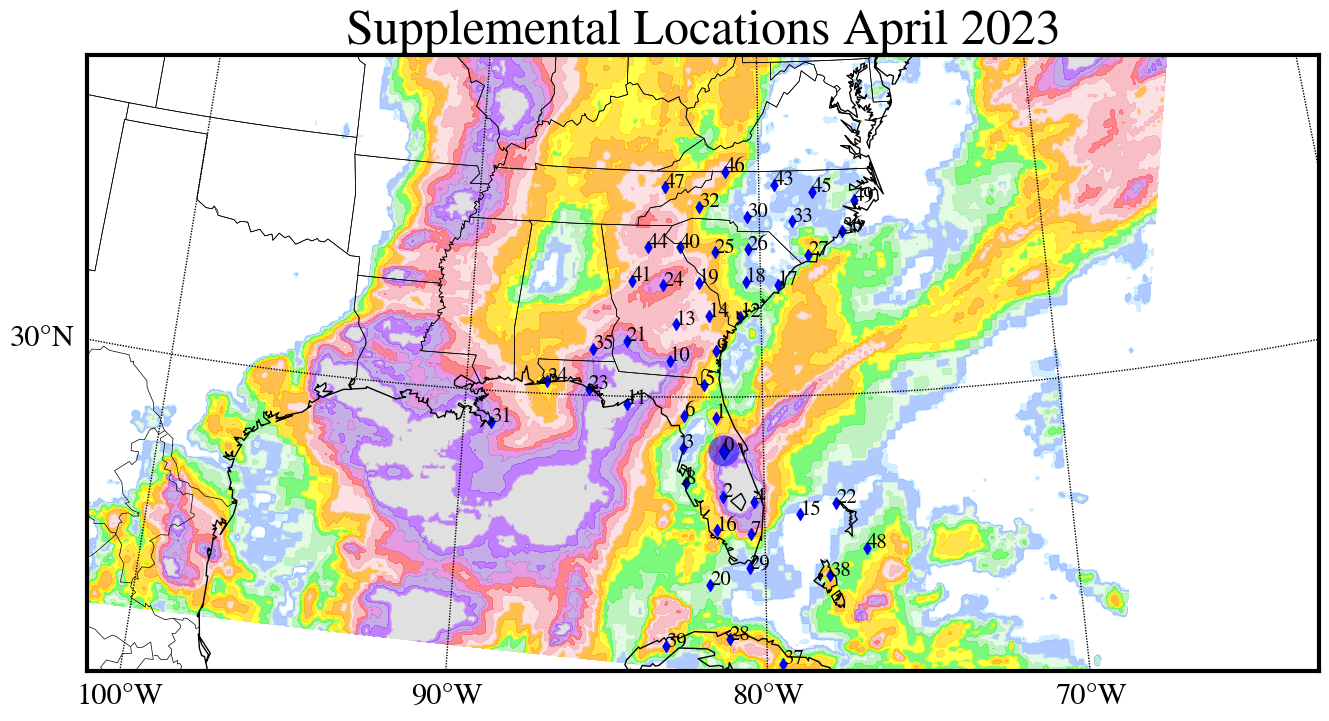

In [85]:
def radius_for_tissot(dist_km): 
    return np.rad2deg(dist_km/6367.) 

fig, axes = plt.subplots(1,1, figsize=(16,8))

clevs_precip = np.array([0.0,0.1,0.3,0.5,0.7,1.0,1.5,2.0,3.0,5.0,7.0,10.0,12.0,15.0,20.,25.])

colorst = ['White','#E4FFFF','#C4E8FF','#8FB3FF','#D8F9D8',\
    '#A6ECA6','#42F742','Yellow','Gold','Orange','#FCD5D9','#F6A3AE',\
        '#FA5257','Orchid','#AD8ADB','#A449FF','LightGray'] 

#GEFS
lats, lons = ds.latitude.data, ds.longitude.data
m = Basemap(projection='lcc',lon_0=-82,lat_0=31,width=4e6,height=2e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,precip_totals,extend='both',ax=axes,levels= clevs_precip,cmap=None, alpha=0.7,colors=colorst)

#supp locations
markers=['o', '*', '^', 'P', 's', 'd']
for loc in [5]:#range(len(station_lats)):
    #plot orgin points
    x, y = m(station_lons[loc], station_lats[loc])  # transform coordinates
    plt.scatter(x, y, s=70, marker=markers[loc], color='black')

    #plot a circle of 50km around given grid point
    #this is *supposed to be* the radius where water SLs would be valid
    lon0, lat0 = station_lons[loc], station_lats[loc]
    m.tissot(lon0, lat0, radius_for_tissot(50), 256, facecolor='b', alpha=0.5)

    #plot SLs
    x_thisloc = xlocs[:,lat_idx[loc], lon_idx[loc]]
    y_thisloc = ylocs[:,lat_idx[loc], lon_idx[loc]]
    #bookkeeping for fortran --> python indices
    x_thisloc = [int(i)-1 for i in x_thisloc]
    y_thisloc = [int(i)-1 for i in y_thisloc]
    #index lat/lon
    sl_lons = lon_arr[y_thisloc, x_thisloc]
    sl_lats = lat_arr[y_thisloc, x_thisloc]
    x, y = m(sl_lons, sl_lats)  # transform coordinates
    for sl_num in range(50):
        plt.annotate(f'{sl_num}', xy=(x[sl_num], y[sl_num]), fontsize=15)
        
        if land_mask[y_thisloc[sl_num], x_thisloc[sl_num]] == 1.0:
            plt.scatter(x[sl_num], y[sl_num], s=35, marker=markers[loc], color='blue')
        else:
            plt.scatter(x[sl_num], y[sl_num], s=35, marker=markers[loc], color='black')


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

plt.title(f'Supplemental Locations {dt.strftime("%B")} 2023')

## Orlando SL indices

In [86]:
loc = 5
lat_idx[loc], lon_idx[loc]

(281, 1815)

In [87]:
x_thisloc = xlocs[:,lat_idx[loc], lon_idx[loc]]
y_thisloc = ylocs[:,lat_idx[loc], lon_idx[loc]]
#bookkeeping for fortran --> python indices
x_thisloc = [int(i)-1 for i in x_thisloc]
y_thisloc = [int(i)-1 for i in y_thisloc]

print('SL    Y    X')
#first SL will be origin point
for sl in range(50):
    print(f'{sl}: {(y_thisloc[sl], x_thisloc[sl])}')

SL    Y    X
0: (281, 1815)
1: (322, 1801)
2: (222, 1819)
3: (280, 1763)
4: (219, 1860)
5: (363, 1782)
6: (321, 1760)
7: (178, 1859)
8: (235, 1771)
9: (408, 1793)
10: (389, 1735)
11: (329, 1685)
12: (454, 1820)
13: (437, 1738)
14: (451, 1779)
15: (209, 1920)
16: (179, 1816)
17: (500, 1864)
18: (500, 1823)
19: (493, 1762)
20: (109, 1814)
21: (409, 1677)
22: (228, 1964)
23: (343, 1635)
24: (485, 1717)
25: (534, 1779)
26: (542, 1821)
27: (542, 1900)
28: (43, 1845)
29: (135, 1862)
30: (584, 1816)
31: (288, 1515)
32: (591, 1753)
33: (583, 1875)
34: (347, 1581)
35: (395, 1635)
36: (577, 1941)
37: (18, 1915)
38: (135, 1964)
39: (27, 1766)
40: (536, 1734)
41: (487, 1676)
42: (6, 1980)
43: (628, 1847)
44: (532, 1692)
45: (624, 1897)
46: (639, 1782)
47: (612, 1707)
48: (174, 2008)
49: (618, 1952)
